## TD Control for Machine Replacement

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def maintenance_cost(state):
    return state**2 + state

def cost_function(state, action, replacement_cost, post_change=False):
    if action == 0:
        return replacement_cost + maintenance_cost(0)
    else:
        if post_change:
            return maintenance_cost_post_change(state)
        return maintenance_cost(state)

def maintenance_cost_post_change(state):
    return  - state**2 + state

In [4]:
# set total number of states and define a transition probability matrix of that size
num_states = 10
replacement_cost = 50
num_changes = 2
transition_probabilities = np.zeros((num_changes + 1, 2, num_states, num_states))

In [5]:
def fill_transition_probability_matrix(transition_probability, p=0.5):
    for j in range(transition_probability.shape[1]-1):
        transition_probability[1][j][j] = p
        transition_probability[1][j][j+1] = 1-p
    for i in range(transition_probability.shape[1]):
        for j in range(transition_probability.shape[2]):
            transition_probability[0][i][j] = transition_probability[1][0][j]
    transition_probability[1, transition_probability.shape[1]-1, transition_probability.shape[1]-1] = 1


In [6]:
def policy_visualization(policy):
    plt.bar(range(num_states), policy)
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.show()

In [7]:
fill_transition_probability_matrix(transition_probabilities[0], p=0.2)
fill_transition_probability_matrix(transition_probabilities[1], p=0.8)
transition_probabilities[2] = transition_probabilities[0].copy()

In [8]:
C = [[[cost_function(state, action, replacement_cost) for state in range(num_states)] for action in range(2)]]

C.append([[cost_function(state, action, replacement_cost, post_change=True) for state in range(num_states)] for action in range(2)])
# C.append([[cost_function(state, action, replacement_cost) for state in range(num_states)] for action in range(2)])
C.append([[cost_function(state, action, replacement_cost) for state in range(num_states)] for action in range(2)])

C = np.array(C)

C


array([[[ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
        [  0,   2,   6,  12,  20,  30,  42,  56,  72,  90]],

       [[ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
        [  0,   0,  -2,  -6, -12, -20, -30, -42, -56, -72]],

       [[ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
        [  0,   2,   6,  12,  20,  30,  42,  56,  72,  90]]])

In [9]:
def T(R, P, V, alpha=0.5):
    return R + alpha* (P @ V)


In [10]:
def evaluate_policy(f, C, P, V, delta=0.01, max_iter=10, transition_probability=None, N=num_states):
    R = np.array([C[int(f[i])][i] for i in range(N)])
    P = np.array([transition_probability[int(f[i]), i, :] for i in range(N) ])
    for i in range(max_iter):
        V_new = T(R, P, V)
        if(np.linalg.norm(V_new-V, np.inf) < delta):
            return V_new
        V = V_new
    return V

In [11]:
def improve_policy_greedy(C, P, V):
    q = [T(C[i], P[i], V) for i in range(2)]
    return np.argmin(q,axis=0), q

In [12]:
def modified_policy_iteration(C, P, max_evaluation_iter=100, initial_policy=np.random.random(num_states), max_iter=100, epsilon=0.01):
    V = np.zeros(num_states)
    V_history = []
    V_history.append(V.copy())
    policy = initial_policy
    q = np.zeros((2, num_states))
    for i in range(max_iter):
        V_new = evaluate_policy(policy, C, P, V, max_iter=max_evaluation_iter, transition_probability=P)
        policy, q = improve_policy_greedy(C, P, V_new)
        print(policy)
        V_history.append(V_new.copy())
        if np.linalg.norm(V_new-V, np.inf) < epsilon:
            return policy, V, V_history, q
        V = V_new
    return policy, V, V_history, q


[1 1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0]
[1 1 1 1 1 0 0 0 0 0]


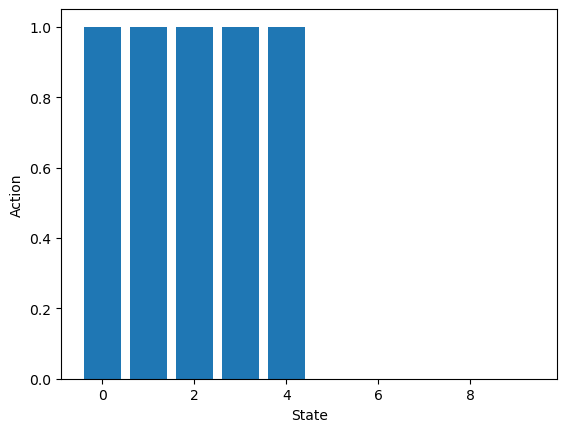

[ 5.30424363 11.93172553 21.84068272 34.13588236 46.8024375  55.30424363
 55.30424363 55.30424363 55.30424363 55.30424363]
[array([55.30208971, 55.30208971, 55.30208971, 55.30208971, 55.30208971,
       55.30208971, 55.30208971, 55.30208971, 55.30208971, 55.30208971]), array([  5.30208971,  11.92831305,  21.83766742,  34.1342328 ,
        46.80143995,  57.65155729,  69.65155729,  83.65155729,
        99.65155729, 117.65155729])]


In [13]:
policy_pre_change, V_pre_change, V_history_pre_change, q_final_pre_change = modified_policy_iteration(C[0], transition_probabilities[0], max_iter=10)
policy_visualization(policy_pre_change)
print(V_pre_change)
print(q_final_pre_change)

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


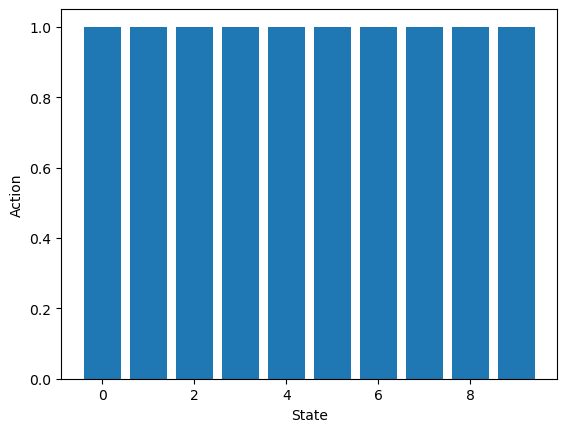

[  -0.15635748   -0.95596553   -5.75544047  -14.55470765  -27.35326014
  -44.14788769  -64.91897186  -89.54827529 -117.32591586 -143.9925539 ]
[array([49.84095116, 49.84095116, 49.84095116, 49.84095116, 49.84095116,
       49.84095116, 49.84095116, 49.84095116, 49.84095116, 49.84095116]), array([  -0.15904884,   -0.9589368 ,   -5.75877969,  -14.55849291,
        -27.35754236,  -44.15266253,  -64.92415668,  -89.55372285,
       -117.33147639, -143.99813847])]


In [14]:
policy_post_change, V_post_change, V_history_post_change, q_final_post_change = modified_policy_iteration(C[1], transition_probabilities[1], max_iter=10)
policy_visualization(policy_post_change)
print(V_post_change)
print(q_final_post_change)

In [15]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            return np.random.randint(0,2)
        else:
            return np.argmin(Q[s])

    def final_policy(self, s, Q):
        if s not in Q:
            return 0
        return np.argmin(Q[s])

In [16]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            return np.random.randint(0,2)
        else:
            return np.argmin(Q[s])

    def final_policy(self, s, Q):
        if s not in Q:
            return 0
        return np.argmin(Q[s])

In [17]:
def qlearning_known_change(policy_class, alpha=0.1, gamma=0.5, max_steps=10000, max_restarts=10, change_times = [], detection_delays=[], should_decay_epsilon=True, initial_epsilon=1.0, transition_probabilities = [transition_probabilities[0]], cost_functions = [C[0]]):

    if len(change_times) != len(detection_delays):
        raise ValueError("change_times and detection_delays must have the same length")

    Q = {}  # state-action value function
    policy = policy_class()

    policy.update(initial_epsilon)  # Initialize epsilon for epsilon-greedy policy

    # Track costs for convergence analysis
    Q_history_qlearning = []

    env_idx = 0

    detected_changes = 0

    transition_probability = transition_probabilities[env_idx]
    cost_fn = cost_functions[env_idx]

    for i in tqdm(range(max_restarts)):
        # Initialize state randomly
        state = np.random.randint(0, num_states)
        # Check if we need to update the environment based on change times and detection delays
        if change_times and detected_changes < len(change_times) and i >= change_times[detected_changes] + detection_delays[detected_changes]:
            policy.update(initial_epsilon)  # Reset epsilon for new environment
            print(f"Detected change at time {i} with delay {detection_delays[detected_changes]}")
            detected_changes += 1

        if change_times and env_idx < len(change_times) and i >= change_times[env_idx]:
            env_idx += 1
            transition_probability = transition_probabilities[env_idx]
            cost_fn = cost_functions[env_idx]

        for step in range(max_steps):
            # Choose initial action using current policy
            action = policy.policy(state, Q)

            # Initialize Q(s,a) if not seen before
            if state not in Q:
                Q[state] = np.zeros(2)

            # Take action and observe cost and next state
            cost = cost_fn[action, state]

            # Sample next state based on transition probabilities
            next_state = np.random.choice(
                num_states,
                p=transition_probability[action, state, :]
            )

            # Initialize Q(s',a') if not seen before
            if next_state not in Q:
                Q[next_state] = np.zeros(2)

            # Q-learning update: Q(s,a) = Q(s,a) + α[r + γmax_a'Q(s',a') - Q(s,a)]
            # Note: we use negative cost as reward since we want to minimize cost
            td_target = cost + gamma * np.min(Q[next_state])
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # Move to next state and action
            state = next_state

            # store largest Q value for each state for convergence analysis
            Q_history_qlearning.append([np.min(Q[s]) if s in Q else 0 for s in range(num_states)])

        # Decay epsilon for epsilon-greedy policy
        if hasattr(policy, 'epsilon') and should_decay_epsilon:
            policy.update(policy.epsilon * 0.9)


    return Q, Q_history_qlearning, policy

In [18]:
Q_history_qlearning = []

# Run Q-learning with epsilon-greedy policy
for detection_delay in [2, 5, 10, float('inf')]:
    print(f"Running Q-learning with Epsilon-Greedy Policy... for delay of {detection_delay} restarts")
    Q_qlearning_final_known_change, Q_history_qlearning_known_change, policy_eg = qlearning_known_change(
        EpsilonGreedyPolicy,
        alpha=0.1, gamma=0.5, max_steps=100, max_restarts=1000,
        change_times=[300, 500], detection_delays=[detection_delay, detection_delay],
        transition_probabilities=transition_probabilities, cost_functions=C
    )
    Q_history_qlearning.append(Q_history_qlearning_known_change)

Running Q-learning with Epsilon-Greedy Policy... for delay of 2 restarts


 34%|███▍      | 343/1000 [00:01<00:03, 194.62it/s]

Detected change at time 302 with delay 2


 53%|█████▎    | 533/1000 [00:02<00:02, 208.82it/s]

Detected change at time 502 with delay 2


100%|██████████| 1000/1000 [00:04<00:00, 202.81it/s]


Running Q-learning with Epsilon-Greedy Policy... for delay of 5 restarts


 36%|███▌      | 358/1000 [00:01<00:03, 197.86it/s]

Detected change at time 305 with delay 5


 55%|█████▍    | 547/1000 [00:02<00:02, 204.31it/s]

Detected change at time 505 with delay 5


100%|██████████| 1000/1000 [00:04<00:00, 204.74it/s]


Running Q-learning with Epsilon-Greedy Policy... for delay of 10 restarts


 35%|███▌      | 352/1000 [00:01<00:03, 209.47it/s]

Detected change at time 310 with delay 10


 57%|█████▋    | 572/1000 [00:02<00:01, 214.12it/s]

Detected change at time 510 with delay 10


100%|██████████| 1000/1000 [00:04<00:00, 208.98it/s]


Running Q-learning with Epsilon-Greedy Policy... for delay of inf restarts


100%|██████████| 1000/1000 [00:04<00:00, 213.77it/s]


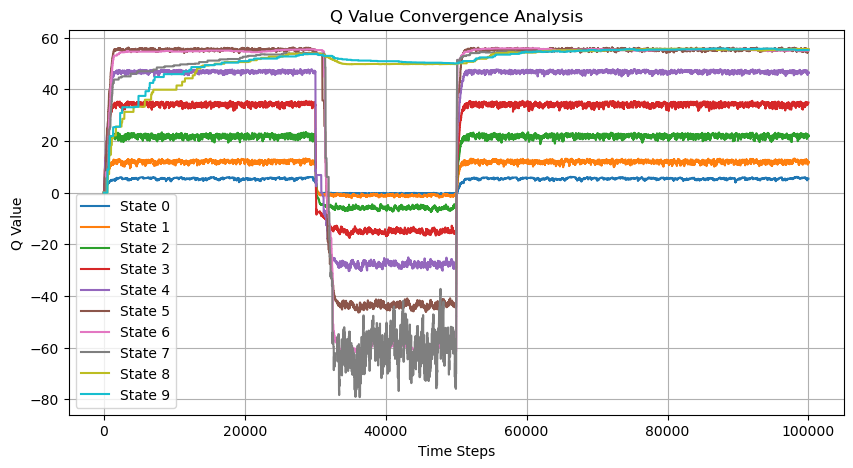

In [19]:
plt.figure(figsize=(10, 5))
for state in range(num_states):
    plt.plot(range(len(Q_history_qlearning[0])), [Q[state] for Q in Q_history_qlearning[0]], label=f'State {state}')
plt.xlabel('Time Steps')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

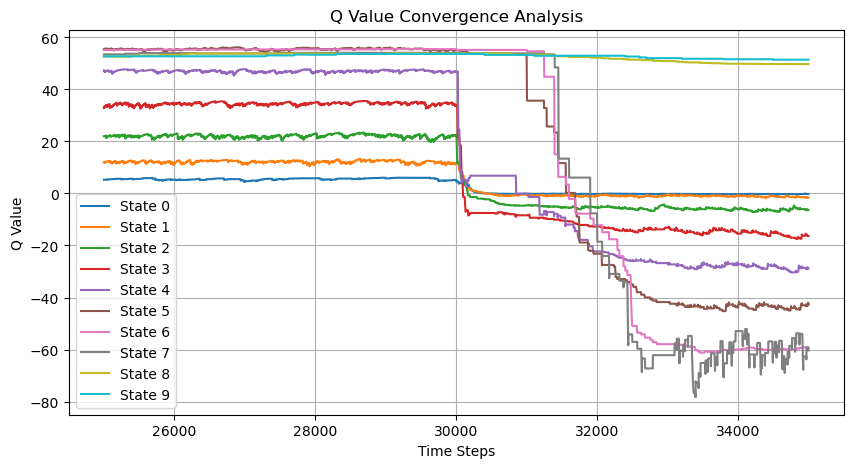

In [20]:
# Zooming in on the plot near the change
# Q value convergence analysis consider best Q value for each state
plt.figure(figsize=(10, 5))
# Plot the Q value for all states over episodes
for state in range(num_states):
    plt.plot(range(25000, 35000), [Q[state] for Q in Q_history_qlearning[0][25000:35000]], label=f'State {state}')
plt.xlabel('Time Steps')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

In [21]:
def plot_comparative(state):
    # Zooming in on the plot near the change
    # Q value convergence comparative analysis consider best Q value
    plt.figure(figsize=(10, 5))
    delays = [2, 5, 10, 'infinite']
    for i in range(4):
        plt.plot(range(20000, 40000), [Q[state] for Q in Q_history_qlearning[i][20000:40000]], label=f'Detection Delay {delays[i]} restarts')
    plt.xlabel('Time Steps')
    plt.ylabel('Q Value')
    plt.title('Q Value Convergence Analysis')
    plt.legend()
    plt.grid()
    plt.show()

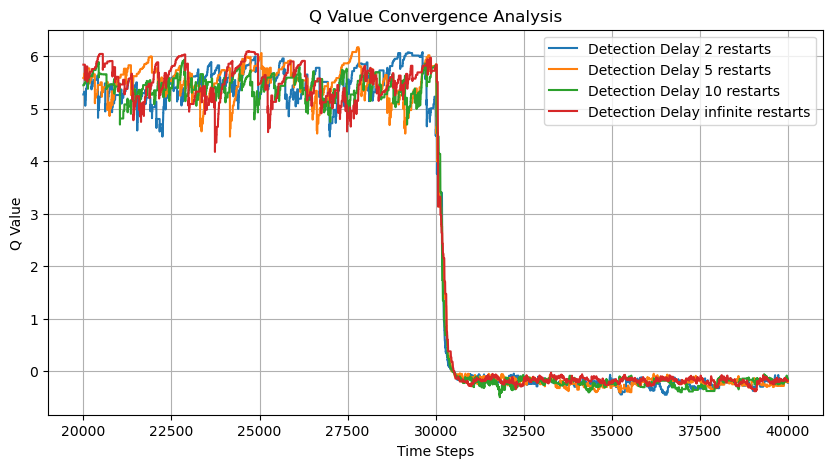

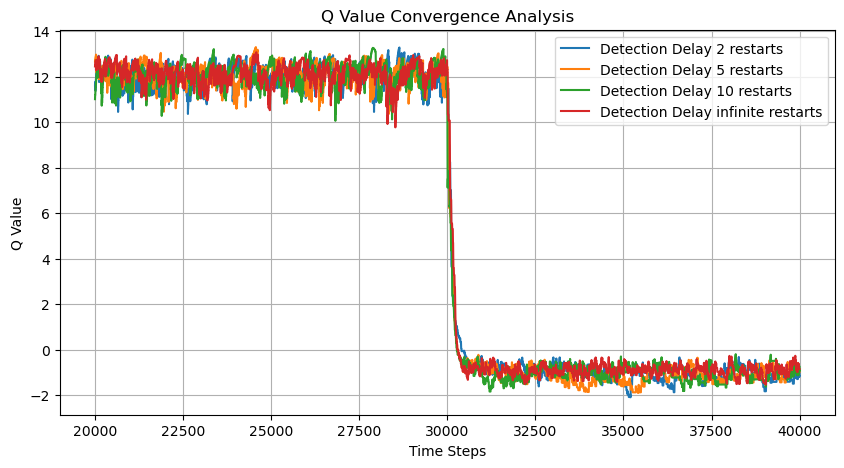

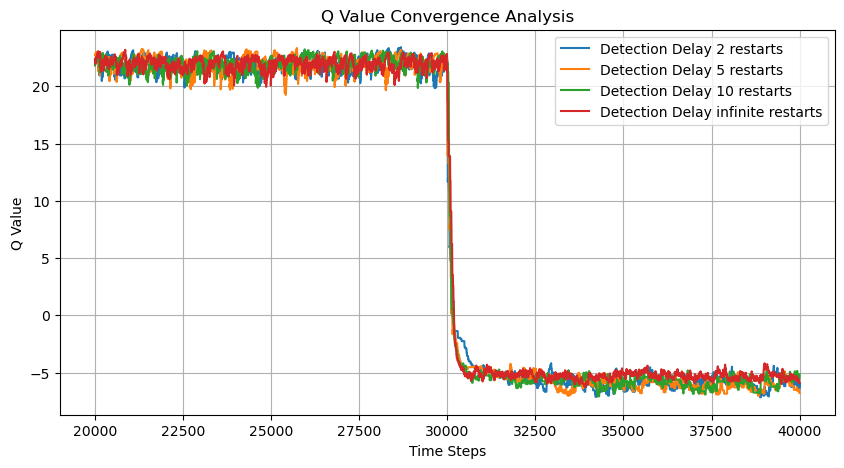

In [22]:
for i in range(3):
    plot_comparative(i)

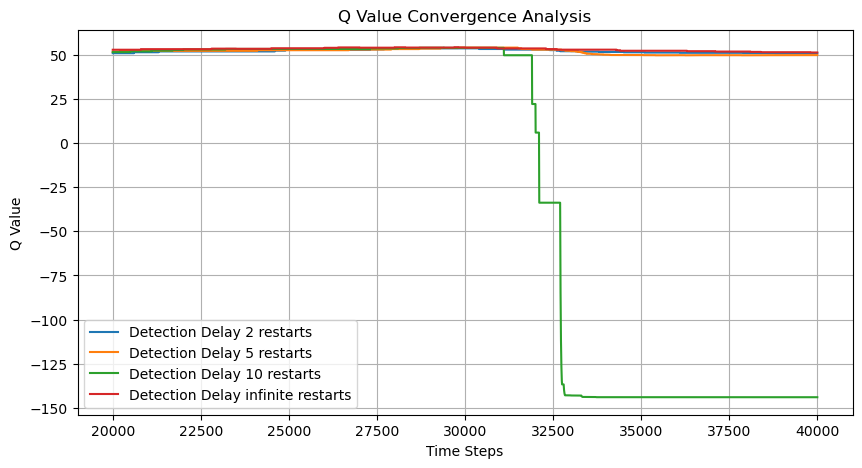

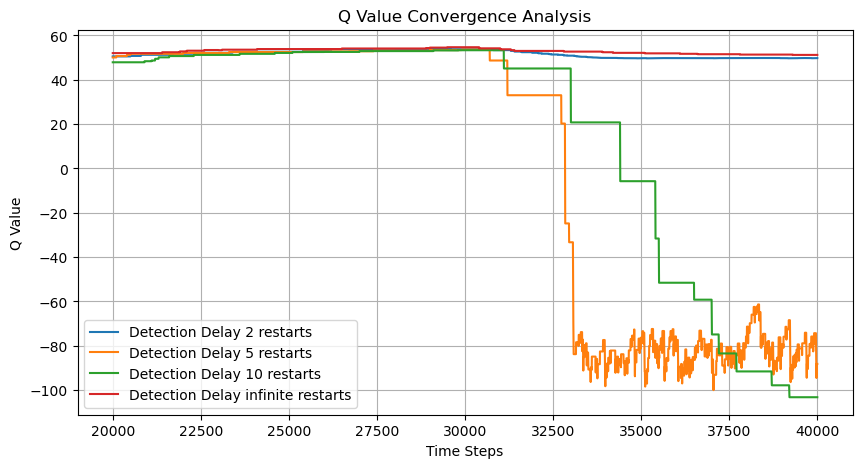

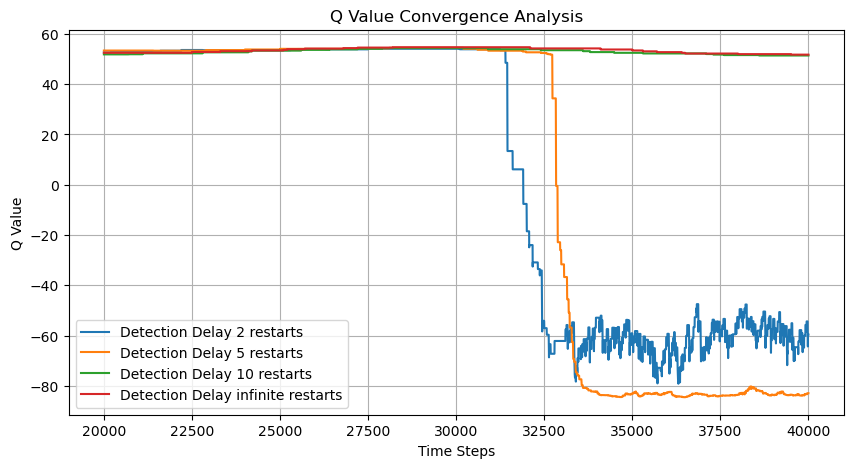

In [23]:
for i in range(3):
    plot_comparative(num_states - i - 1)

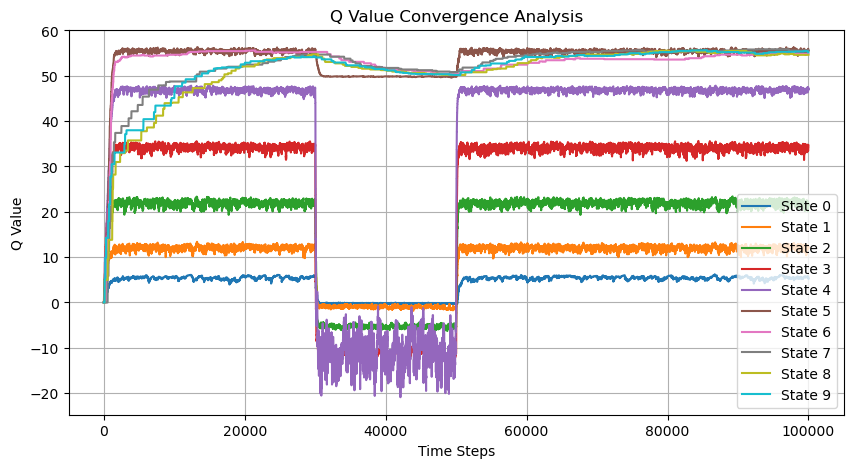

In [24]:
plt.figure(figsize=(10, 5))
for state in range(num_states):
    plt.plot(range(len(Q_history_qlearning[-1])), [Q[state] for Q in Q_history_qlearning[-1]], label=f'State {state}')
plt.xlabel('Time Steps')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

In [25]:
detection_delay = float('inf')
print(f"Running Q-learning with Epsilon-Greedy Policy... for delay of {detection_delay} restarts")
Q_qlearning_final_no_epsilon_decay, Q_history_qlearning_no_epsilon_decay, policy_eg = qlearning_known_change(
    EpsilonGreedyPolicy,
    alpha=0.1, gamma=0.5, max_steps=100, max_restarts=1000,
    change_times=[300, 500], detection_delays=[detection_delay, detection_delay],
    transition_probabilities=transition_probabilities, cost_functions=C,
    initial_epsilon=0.1, should_decay_epsilon=False
)

Running Q-learning with Epsilon-Greedy Policy... for delay of inf restarts


100%|██████████| 1000/1000 [00:04<00:00, 213.12it/s]


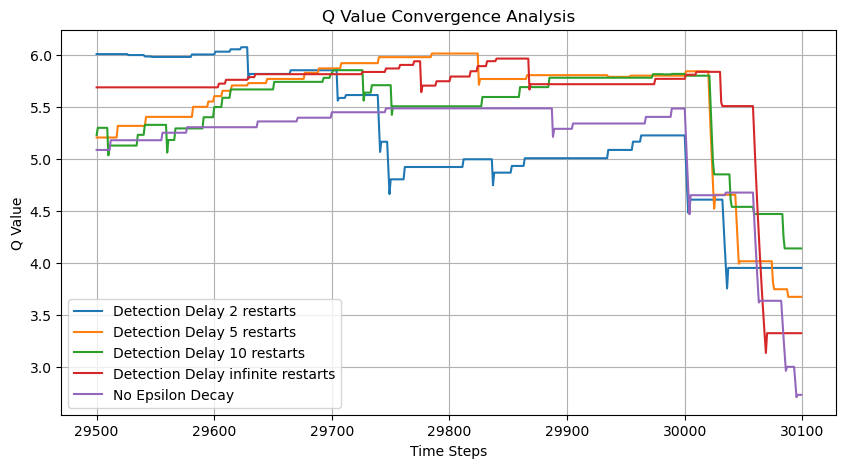

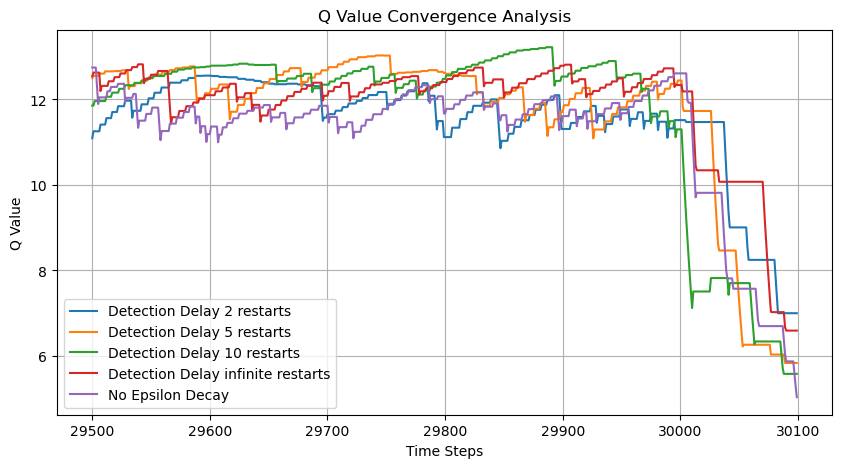

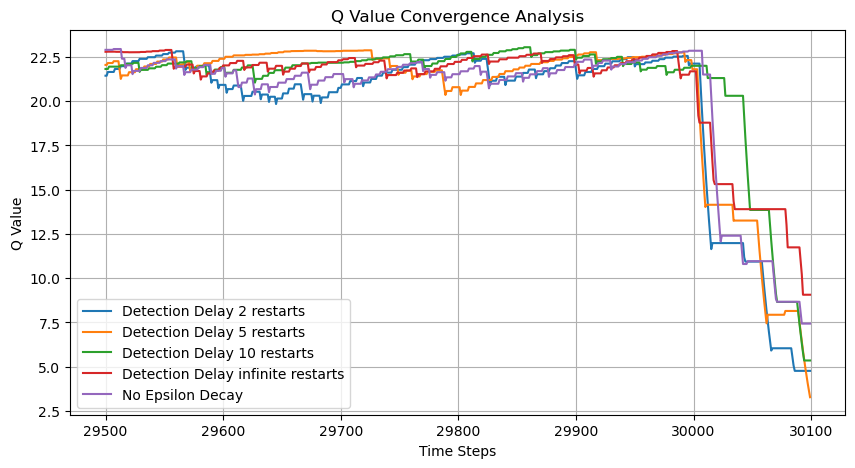

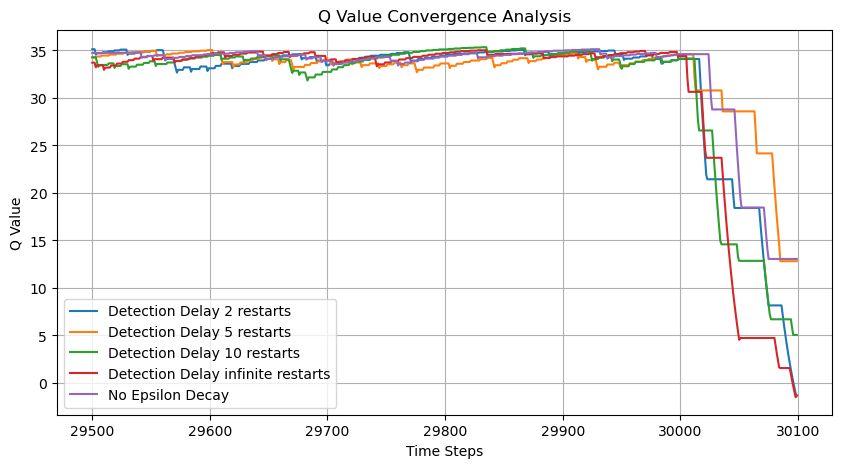

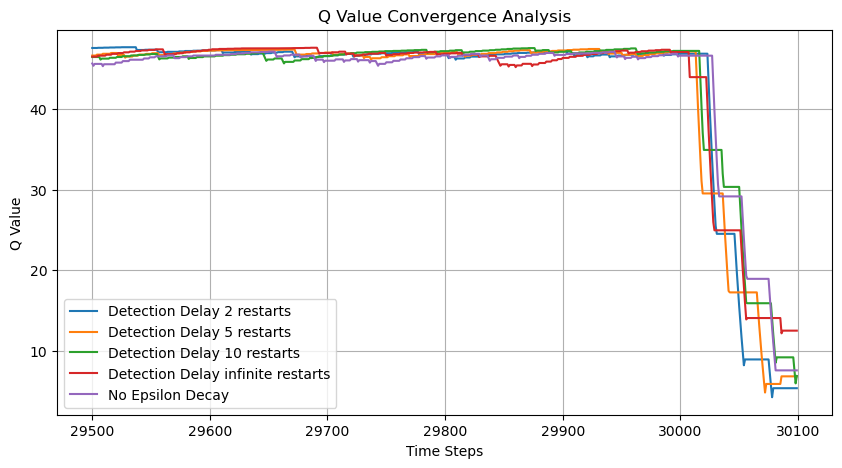

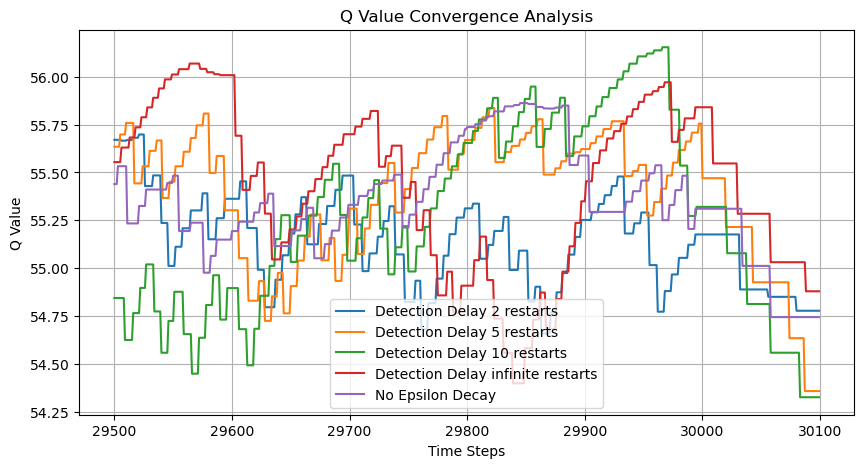

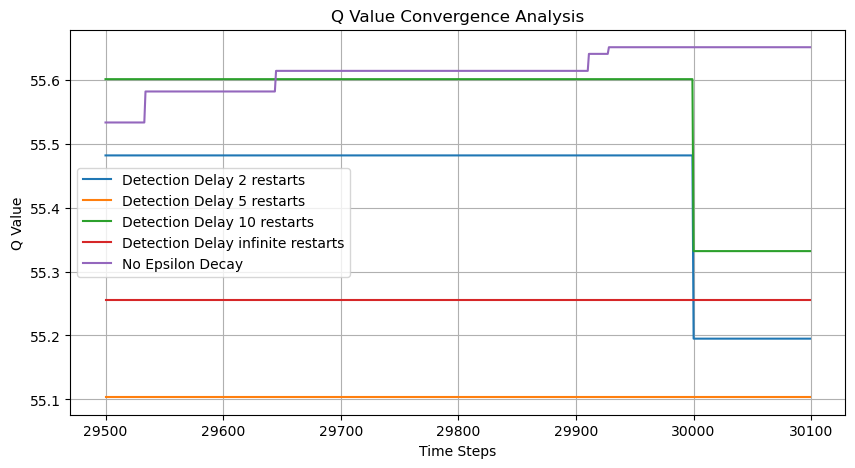

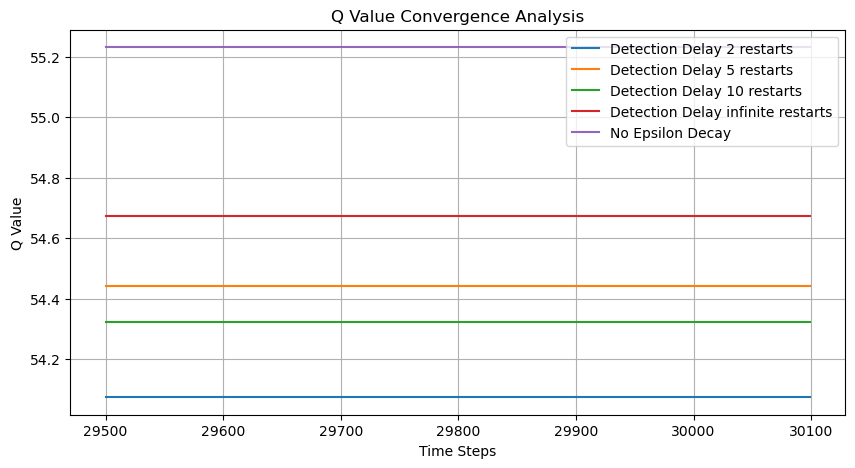

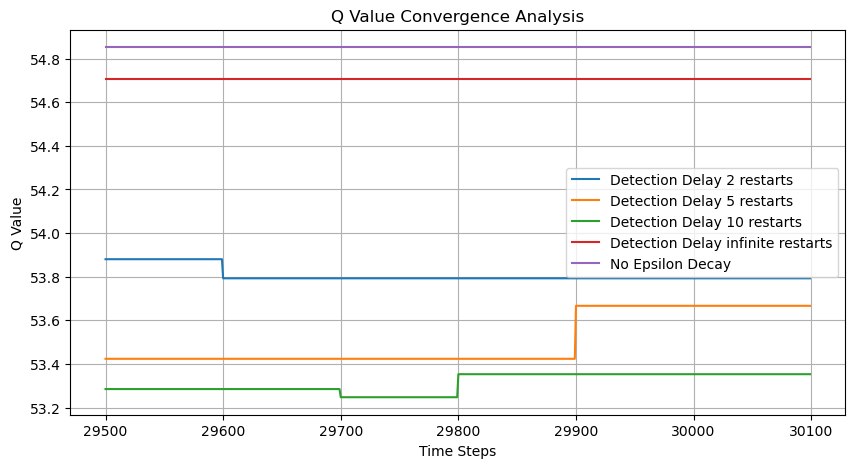

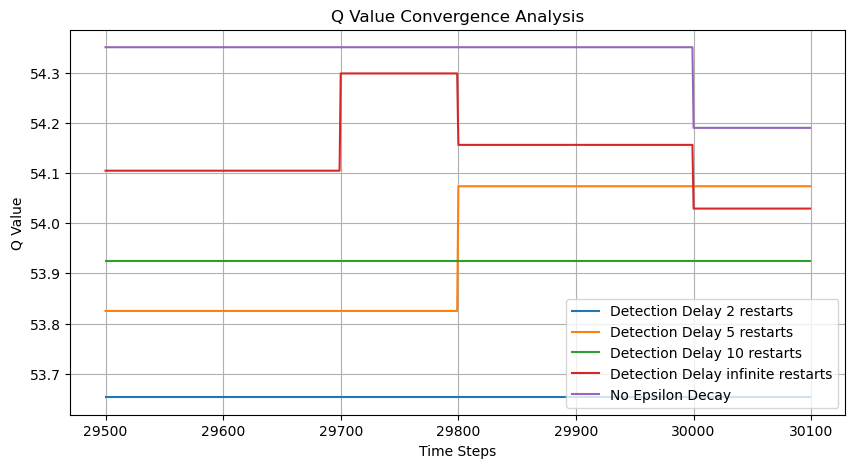

In [29]:
for state in range(num_states):
    # Zooming in on the plot near the change
    # Q value convergence comparative analysis consider best Q value
    plt.figure(figsize=(10, 5))
    delays = [2, 5, 10, 'infinite']
    for i in range(4):
        plt.plot(range(29500, 30100), [Q[state] for Q in Q_history_qlearning[i][29500:30100]], label=f'Detection Delay {delays[i]} restarts')
    plt.plot(range(29500, 30100), [Q[state] for Q in Q_history_qlearning_no_epsilon_decay[29500:30100]], label='No Epsilon Decay')
    plt.xlabel('Time Steps')
    plt.ylabel('Q Value')
    plt.title('Q Value Convergence Analysis')
    plt.legend()
    plt.grid()
    plt.show()

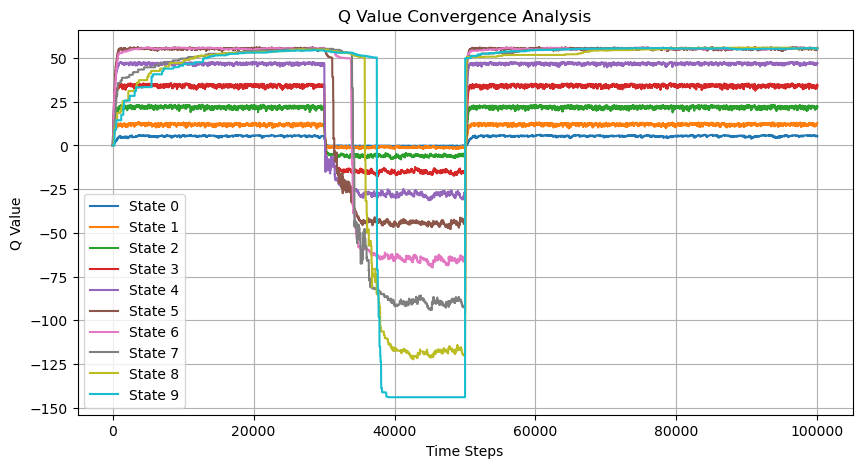

In [27]:
plt.figure(figsize=(10, 5))
for state in range(num_states):
    plt.plot(range(len(Q_history_qlearning_no_epsilon_decay)), [Q[state] for Q in Q_history_qlearning_no_epsilon_decay], label=f'State {state}')
plt.xlabel('Time Steps')
plt.ylabel('Q Value')
plt.title('Q Value Convergence Analysis')
plt.legend()
plt.grid()
plt.show()

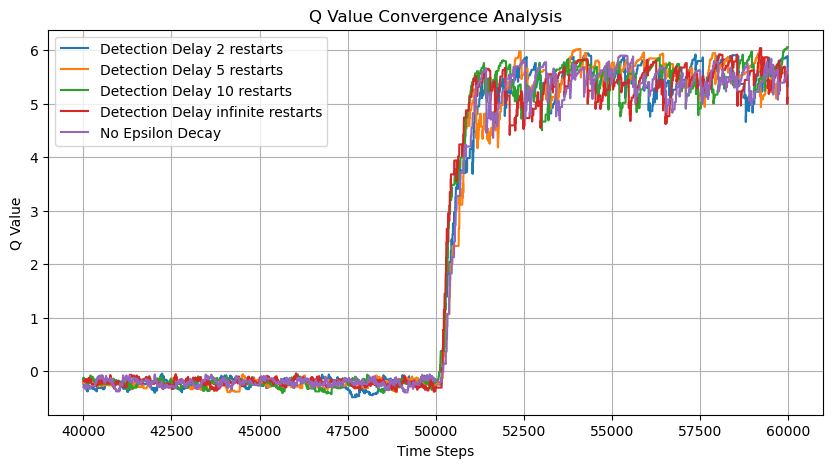

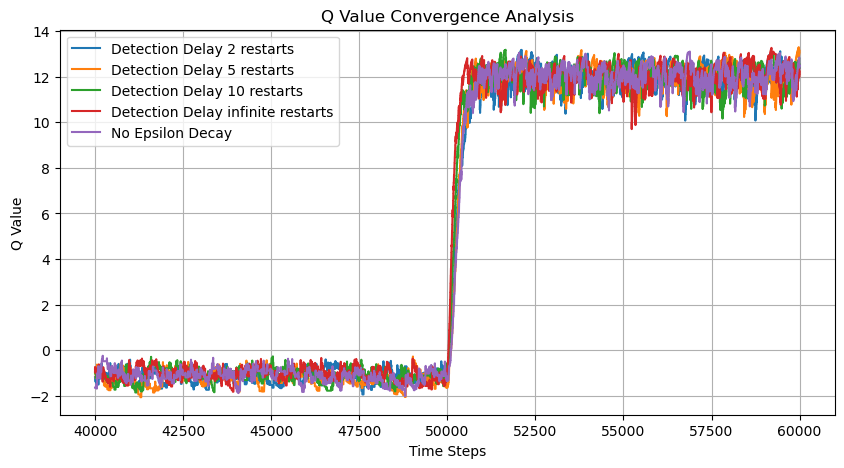

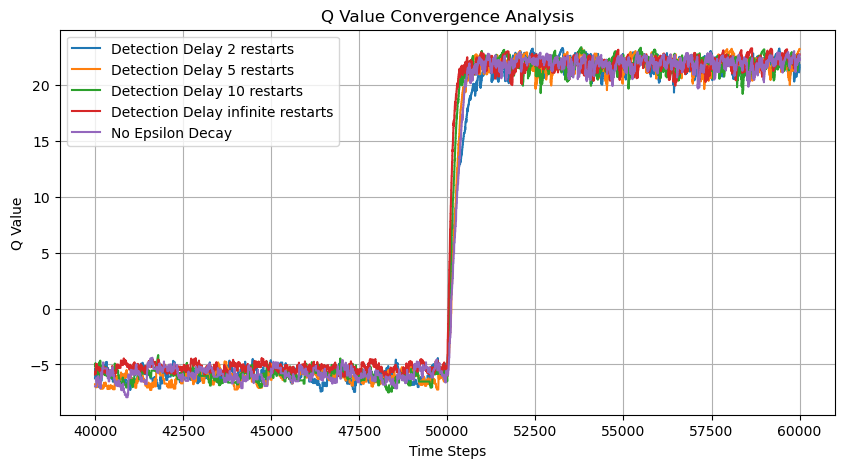

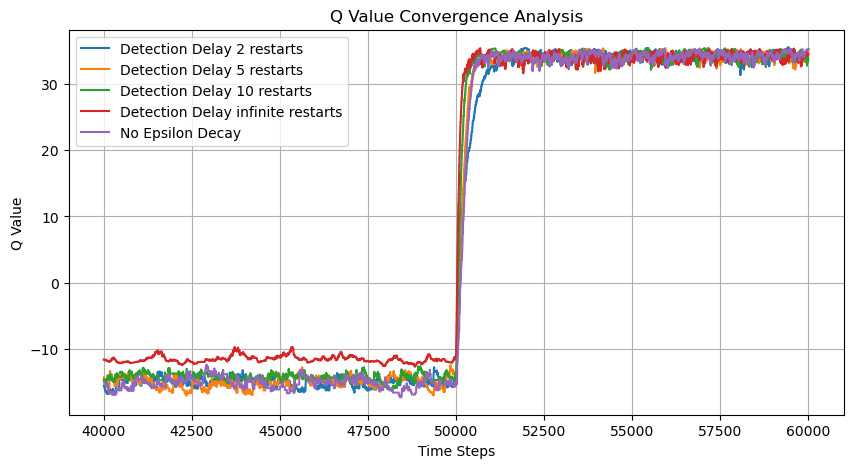

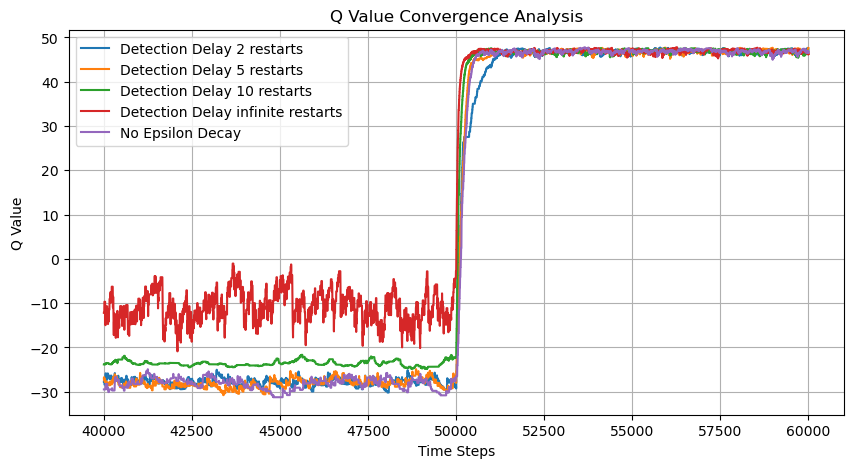

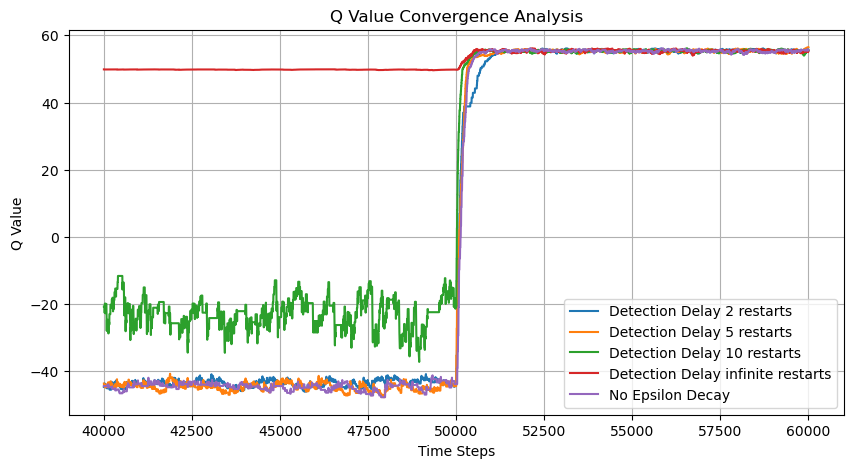

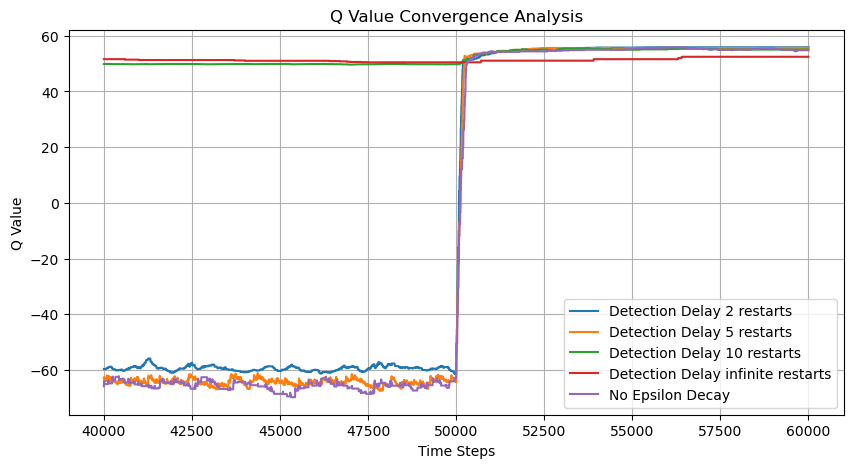

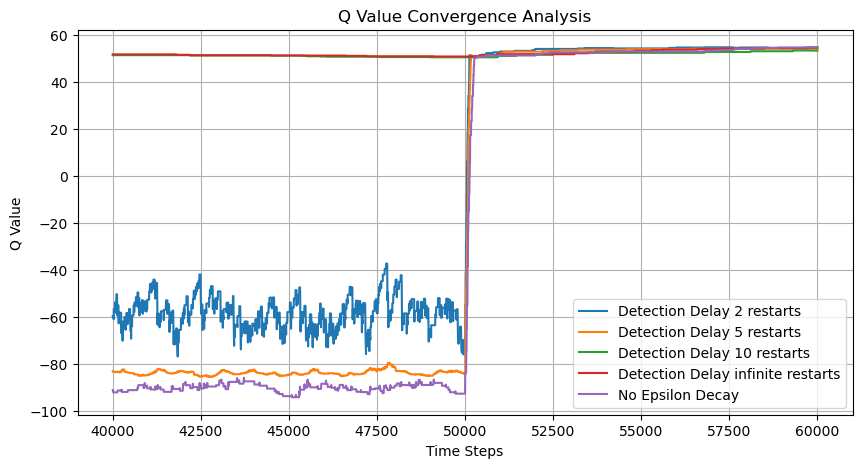

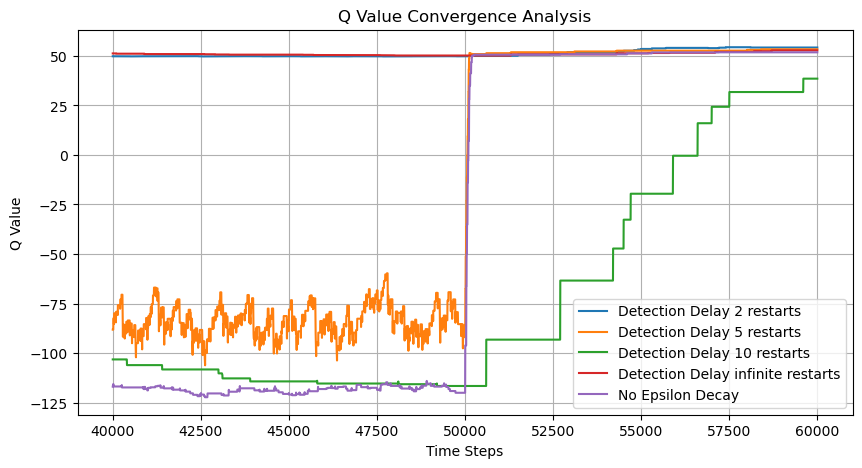

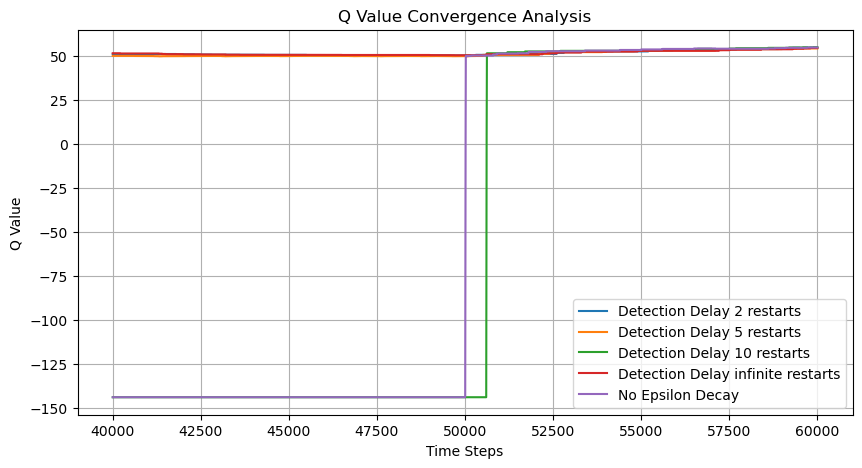

In [28]:
for state in range(num_states):
    # Zooming in on the plot near the change
    # Q value convergence comparative analysis consider best Q value
    plt.figure(figsize=(10, 5))
    delays = [2, 5, 10, 'infinite']
    for i in range(4):
        plt.plot(range(40000, 60000), [Q[state] for Q in Q_history_qlearning[i][40000:60000]], label=f'Detection Delay {delays[i]} restarts')
    plt.plot(range(40000, 60000), [Q[state] for Q in Q_history_qlearning_no_epsilon_decay[40000:60000]], label='No Epsilon Decay')
    plt.xlabel('Time Steps')
    plt.ylabel('Q Value')
    plt.title('Q Value Convergence Analysis')
    plt.legend()
    plt.grid()
    plt.show()